## Загрузка данных и подключение библиотек

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c geekbrains-competitive-data-analysis

kaggle.json
  0% 0.00/632k [00:00<?, ?B/s]
100% 632k/632k [00:00<00:00, 54.3MB/s]
  0% 0.00/434k [00:00<?, ?B/s]
100% 434k/434k [00:00<00:00, 58.8MB/s]
 68% 41.0M/59.9M [00:00<00:00, 41.8MB/s]
100% 59.9M/59.9M [00:00<00:00, 82.1MB/s]
 57% 12.0M/21.0M [00:00<00:00, 47.4MB/s]
100% 21.0M/21.0M [00:00<00:00, 70.1MB/s]
 67% 17.0M/25.2M [00:00<00:00, 27.0MB/s]
100% 25.2M/25.2M [00:00<00:00, 46.7MB/s]
  0% 0.00/586k [00:00<?, ?B/s]
100% 586k/586k [00:00<00:00, 85.2MB/s]
 68% 8.00M/11.7M [00:00<00:00, 82.1MB/s]
100% 11.7M/11.7M [00:00<00:00, 76.9MB/s]


In [ ]:
!pip install catboost
!pip install eli5
!pip install shap
!unzip /content/applications_history.csv.zip
!unzip /content/bki.csv.zip
!unzip /content/client_profile.csv.zip
!unzip /content/payments.csv.zip
!unzip /content/sample_submit.csv.zipa
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/applications_history.csv.zip
  inflating: applications_history.csv  
Archive:  /content/bki.csv.zip
  inflating: bki.csv                 
Archive:  /content/client_profile.csv.zip
  inflating: client_profile.csv      
Archive:  /content/payments.csv.zip
  inflating: payments.csv            
unzip:  cannot find or open /content/sample_submit.csv.zipa, /content/sample_submit.csv.zipa.zip or /content/sample_submit.csv.zipa.ZIP.
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
from typing import List, Optional
from sklearn.model_selection import KFold, cross_val_score
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import math
import eli5
import time
import lightgbm as lgb
import shap
import missingno as msno
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, KFold

## Используемые функции

In [ ]:
def plot_feature_importance(importance, names, model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  return list(fi_df['feature_names'].values)

In [ ]:
def get_input(data_path: str) -> pd.DataFrame:
  """
  Считывание данных и вывод основной информации о наборе данных.

  Parmeters
  ---------
  data_path: str - название файла

  Returns
  -------
  data: pandas.core.frame.DataFrame - загруженный набор данных в pandas.Dataframe
  """
  base_path = "/content"
  data = pd.read_csv(f"{base_path}/{data_path}")
  data.columns = [col.lower() for col in data.columns]
  print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
  return data

In [ ]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [ ]:
def get_features_type(df: pd.DataFrame,
                      treashold: int = 25) -> List:
    """
    Функция для определения числовых признаков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных.
    
    treashold: int
        Порог. Если число уникальных значений числового признака меньше порога,
        то этот признак будем считать дискретным.
        Опциональный параметр, значение по умолчанию 25

    Returns
    -------
    numerical_features: List
        Список с названиями числовых признаков.
    categorical_features: List
        Список с названиями категориальных признаков.
    discrete_feature: List
        Список с названиями дискретных признаков из числа числовых признаков.


    """
    df_dtypes = df.dtypes
    numerical_features = df_dtypes[df_dtypes.values != np.object].index.to_list()
    categorical_features = df_dtypes[df_dtypes.values == np.object].index.to_list()
    discrete_features = [feature for feature in numerical_features if df[feature].nunique() < 25]
    assert (len(numerical_features) + len(categorical_features)) == df.shape[1]
    print(f"Number of numerical features {len(numerical_features)}")
    print(f"Number of categorical features {len(categorical_features)}")
    print(f"Number of discrete features in numerical features {len(discrete_features)}")
    print(f"Total number of features {df.shape[1]}")
    return numerical_features, categorical_features, discrete_features

In [ ]:
def get_target_statistics(df: pd.DataFrame, tagret: str) -> pd.DataFrame:
    
    """
    Функция для вычисления распределения целевой переменной в задаче классификации.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных.
    
    tagret: str
        Название целевой переменной

    Returns
    -------
    statistics: pandas.core.DataFrame
    
    """

    statistics = df.target.value_counts().reset_index()
    statistics.rename(columns = {"index": 'target value', tagret: 'num'}, inplace=True)
    statistics['percent'] = statistics['num']/sum(statistics['num'])
    sns.barplot(x=statistics['target value'], y=statistics['percent'])
    return statistics

## Исследование непрерывных числовых признаков client_profile

In [ ]:
client_profile = get_input("client_profile.csv")
test = get_input("test.csv")
train = get_input("train.csv")

client_profile.csv: shape = 250000 rows, 24 cols
test.csv: shape = 165141 rows, 2 cols
train.csv: shape = 110093 rows, 3 cols


In [ ]:
train_ext = pd.merge(train, client_profile, how='left', on='application_number')
test_ext = pd.merge(test, client_profile, how='left', on='application_number')

In [ ]:
numerical_features, categorical_features, discrete_features = get_features_type(train_ext)
numerical_features.remove('target')
discrete_features.remove('target')

Number of numerical features 22
Number of categorical features 4
Number of discrete features in numerical features 11
Total number of features 26


### Исследование целевой переменной

,target value,num,percent
0,0,101196,0.919187
1,1,8897,0.080813


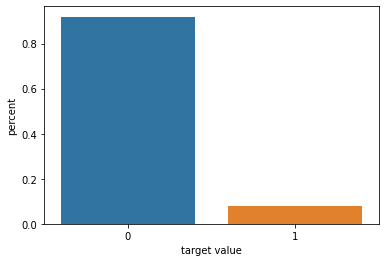

In [ ]:
get_target_statistics(train_ext, 'target')

### Исследование распределений непрерывных числовых признаков при разных значениях целевой переменной

In [ ]:
cont_features = list(set(numerical_features) - set(discrete_features))
cont_features.remove('application_number')

In [ ]:
def get_cont_features_dist_from_target(df: pd.DataFrame, 
                                       selected_features: List, 
                                       tagret: str, 
                                       n_columns: int = 3,
                                       sublot_size: tuple = (5, 4),
                                       space: float = 3.0):
  
  n_rows = math.ceil((len(selected_features) / n_columns))
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)

  for num, feature in enumerate(selected_features):
    sns.kdeplot(df.loc[df.target == 0][feature], ax=axes[num//n_columns, num%n_columns], color="blue", label='Target=0', fill=True)
    sns.kdeplot(df.loc[df.target == 1][feature], ax=axes[num//n_columns, num%n_columns], color="green", label='Target=1', fill=True)
    axes[num//n_columns, num%n_columns].legend()

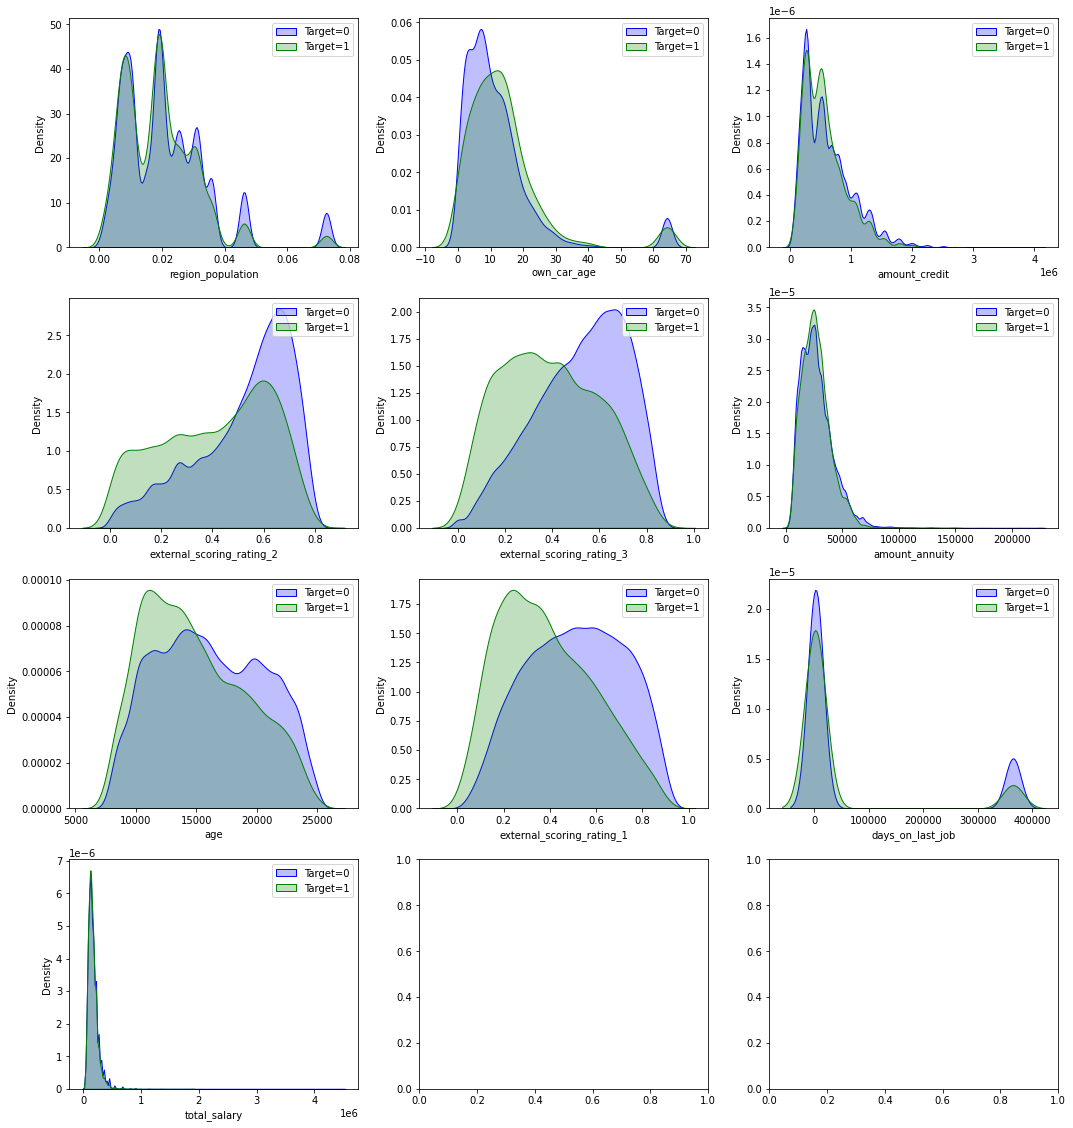

In [ ]:
get_cont_features_dist_from_target(train_ext, cont_features, 'target', n_columns=3, sublot_size=(5, 4))

### Исследование распределения непрерывных числовых признаков в train и test

In [ ]:
def get_train_test_cont_distr(df_train: pd.DataFrame, 
                              df_test: pd.DataFrame, 
                              selected_features: List,
                              n_columns: int = 3,
                              sublot_size: tuple = (5, 4),
                              space: float = 3.0):

  n_rows = math.ceil((len(selected_features) / n_columns))
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)
  
  for num, feature in enumerate(selected_features):
      try:
          train_feature, test_feature = df_train[feature].copy(), df_test[feature].copy()
          sns.kdeplot(train_feature, ax=axes[num//n_columns, num%n_columns], color="blue", label="train", fill=True)
          sns.kdeplot(test_feature, ax=axes[num//n_columns, num%n_columns], color="green", label="test", fill=True)
          axes[num//n_columns, num%n_columns].legend()
      except RuntimeError:
          pass
      except KeyError:
          train_feature = df_train[feature].copy()
          sns.kdeplot(train_feature, ax=axes[num//n_columns, num%n_columns], color="blue", label="train", fill=True)
          axes[num//n_columns, num%n_columns].legend()

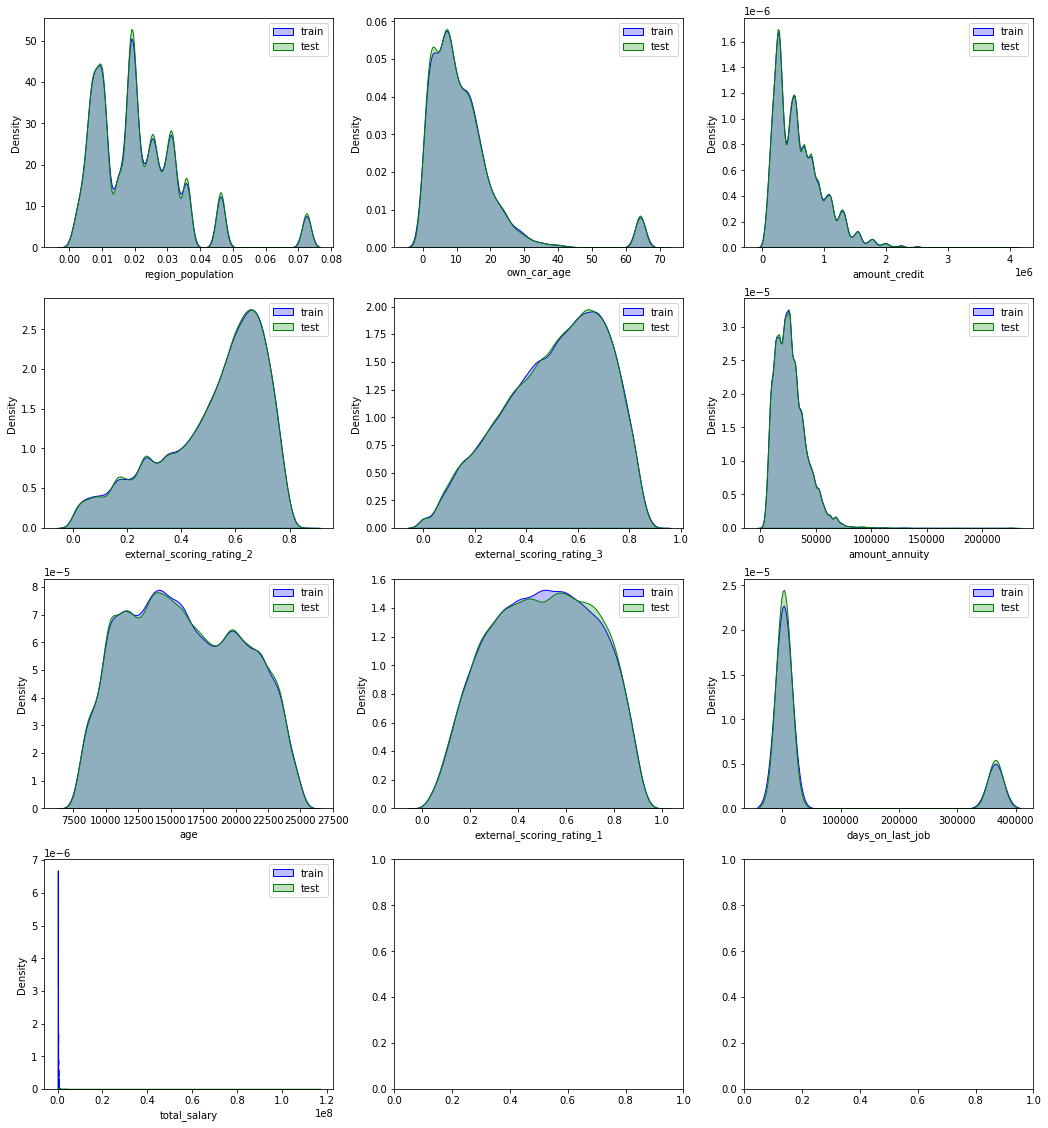

In [ ]:
get_train_test_cont_distr(train_ext, test_ext, cont_features, n_columns=3, sublot_size=(5, 4))

### Исследование данных на наличие выбросов

In [ ]:
def get_boxplots(df: pd.DataFrame, 
                 selected_features: List,
                 n_columns: int = 3,
                 sublot_size: tuple = (5, 4),
                 space: float = 3.0):
  
  n_rows = math.ceil((len(selected_features) / n_columns))
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)
  for num, feature in enumerate(selected_features):
    train_feature = df[feature].copy()
    sns.boxplot(y=train_feature, ax=axes[num//n_columns, num%n_columns], color="blue")

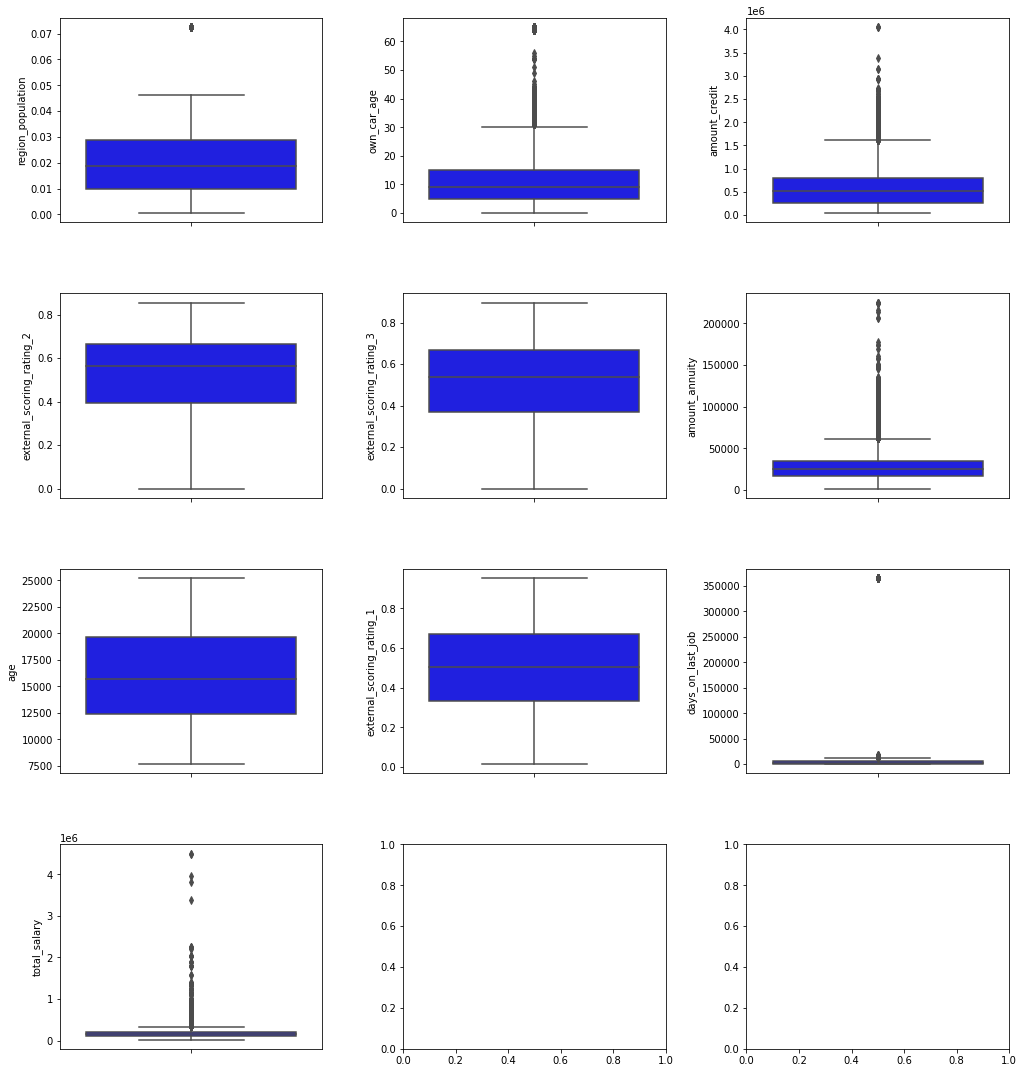

In [ ]:
get_boxplots(train_ext, cont_features, n_columns=3, sublot_size=(5, 4), space=5.0)

## Исследование категориальных признаков client_profile

In [ ]:
def mean_target_from_categorical(data: pd.DataFrame, 
                                selected_features: List, 
                                target: str,
                                n_columns: int = 3,
                                sublot_size: tuple = (5, 4),
                                space: float = 3.0):
  
  n_rows = math.ceil((len(selected_features) / n_columns))
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)

  for num, feature in enumerate(selected_features):
    scatistic = data.groupby(feature)[target].mean()
    chart = sns.barplot(x=scatistic.index, y=scatistic.values, ax=axes[num//n_columns, num%n_columns])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=35)
    axes[num//n_columns, num%n_columns].set_title(f'mean target from {feature}', pad = 0)
    axes[num//n_columns, num%n_columns].set(xlabel=None)

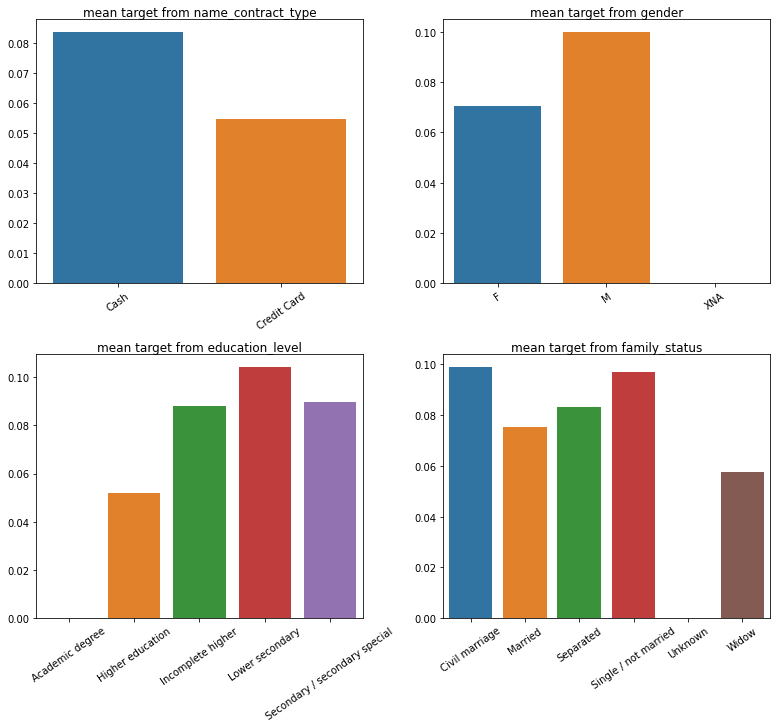

In [ ]:
mean_target_from_categorical(train_ext, categorical_features, 'target', n_columns=2, sublot_size=(6, 5), space=5.0)

In [ ]:
def get_cat_features_dist_from_target(df: pd.DataFrame, 
                                       selected_features: List, 
                                       tagret: str, 
                                       n_columns: int = 3,
                                       sublot_size: tuple = (5, 4),
                                       space: float = 3.0):
  
  n_rows = math.ceil((len(selected_features) / n_columns))
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)

  for num, feature in enumerate(selected_features):
    statistic_0 = df.loc[df['target']==0, feature].value_counts()
    statistic_1 = df.loc[df['target']==1, feature].value_counts()

    statistic_0[statistic_0.index] = statistic_0.values / sum(statistic_0.values)
    statistic_1[statistic_1.index] = statistic_1.values / sum(statistic_1.values)

    sns.barplot(x=statistic_0.index, y=statistic_0.values, ax=axes[num//n_columns, num%n_columns], color='red', label='Target=0')
    sns.barplot(x=statistic_1.index, y=statistic_1.values, ax=axes[num//n_columns, num%n_columns], color='blue', label='Target=1')
    for bar in axes[num//n_columns, num%n_columns].containers[1]:
      bar.set_alpha(0.7)
    for bar in axes[num//n_columns, num%n_columns].containers[0]:
      bar.set_alpha(0.7)

    #chart_1 = sns.barplot(x=statistic_1.index, y=statistic_1.values, ax=axes[num//n_columns, num%n_columns], color='blue', label='Target=1')
    #for bar in chart_1.containers[1]:
    #  bar.set_alpha(0.6)
    
    axes[num//n_columns, num%n_columns].set_title(f'{feature} distribution', pad = 0)
    axes[num//n_columns, num%n_columns].set_xticklabels(axes[num//n_columns, num%n_columns].get_xticklabels(), rotation=20)
    axes[num//n_columns, num%n_columns].legend()

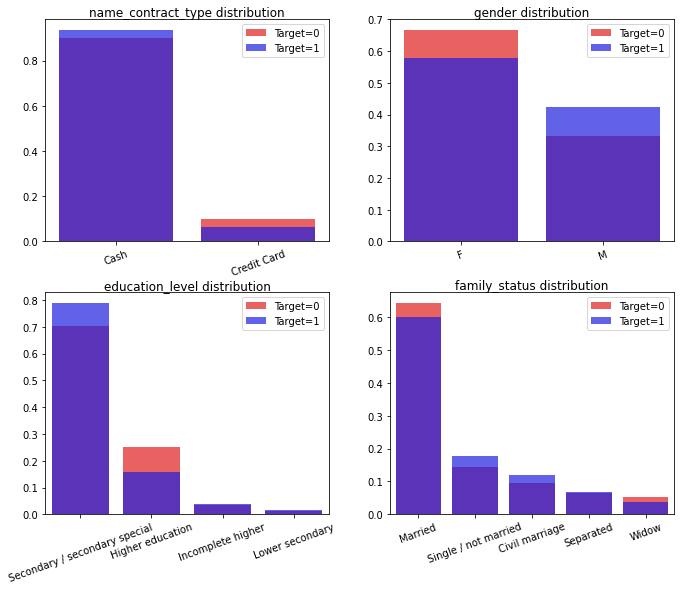

In [ ]:
get_cat_features_dist_from_target(train_ext, categorical_features, 'tagret', n_columns=2, sublot_size=(5, 4))

In [ ]:
def get_train_test_cat_distr(df_train: pd.DataFrame, 
                              df_test: pd.DataFrame, 
                              selected_features: List,
                              n_columns: int = 3,
                              sublot_size: tuple = (5, 4),
                              space: float = 3.0):

  n_rows = math.ceil((len(selected_features) / n_columns))
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)
  
  for num, feature in enumerate(selected_features):
    statistic_train = df_train[feature].value_counts()
    statistic_test = df_test[feature].value_counts()

    statistic_train[statistic_train.index] = statistic_train.values / sum(statistic_train.values)
    statistic_test[statistic_test.index] = statistic_test.values / sum(statistic_test.values)
    try:
      sns.barplot(x=statistic_train.index, y=statistic_train.values, ax=axes[num//n_columns, num%n_columns], color='red', label='train')
      sns.barplot(x=statistic_test.index, y=statistic_test.values, ax=axes[num//n_columns, num%n_columns], color='blue', label='test')
      axes[num//n_columns, num%n_columns].legend()
      for bar in axes[num//n_columns, num%n_columns].containers[1]:
        bar.set_alpha(0.7)
      for bar in axes[num//n_columns, num%n_columns].containers[0]:
        bar.set_alpha(0.7)
      axes[num//n_columns, num%n_columns].set_title(f'{feature} distribution', pad = 0)
      axes[num//n_columns, num%n_columns].set_xticklabels(axes[num//n_columns, num%n_columns].get_xticklabels(), rotation=20)
    except RuntimeError:
      pass
    except KeyError:
      sns.barplot(x=statistic_train.index, y=statistic_train.values, ax=axes[num//n_columns, num%n_columns], color='red', label='train')
      axes[num//n_columns, num%n_columns].legend()

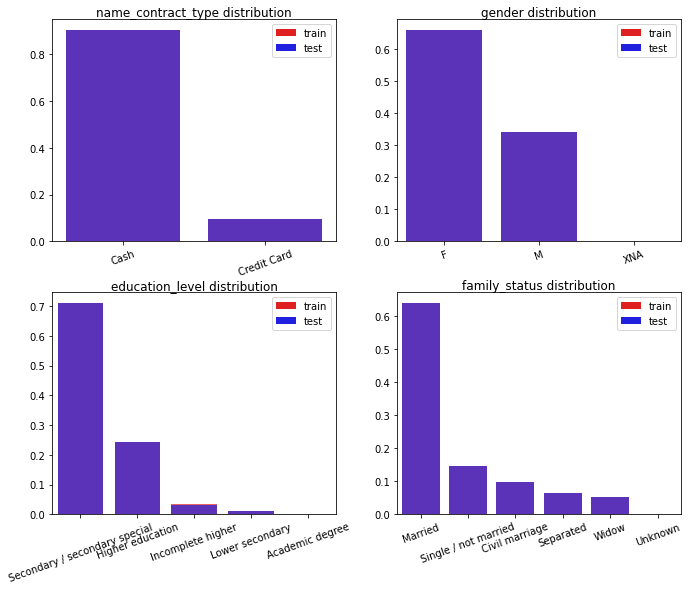

In [ ]:
get_train_test_cat_distr(train_ext, test_ext, categorical_features, n_columns=2)

## Исследование дискретных признаков client_profile

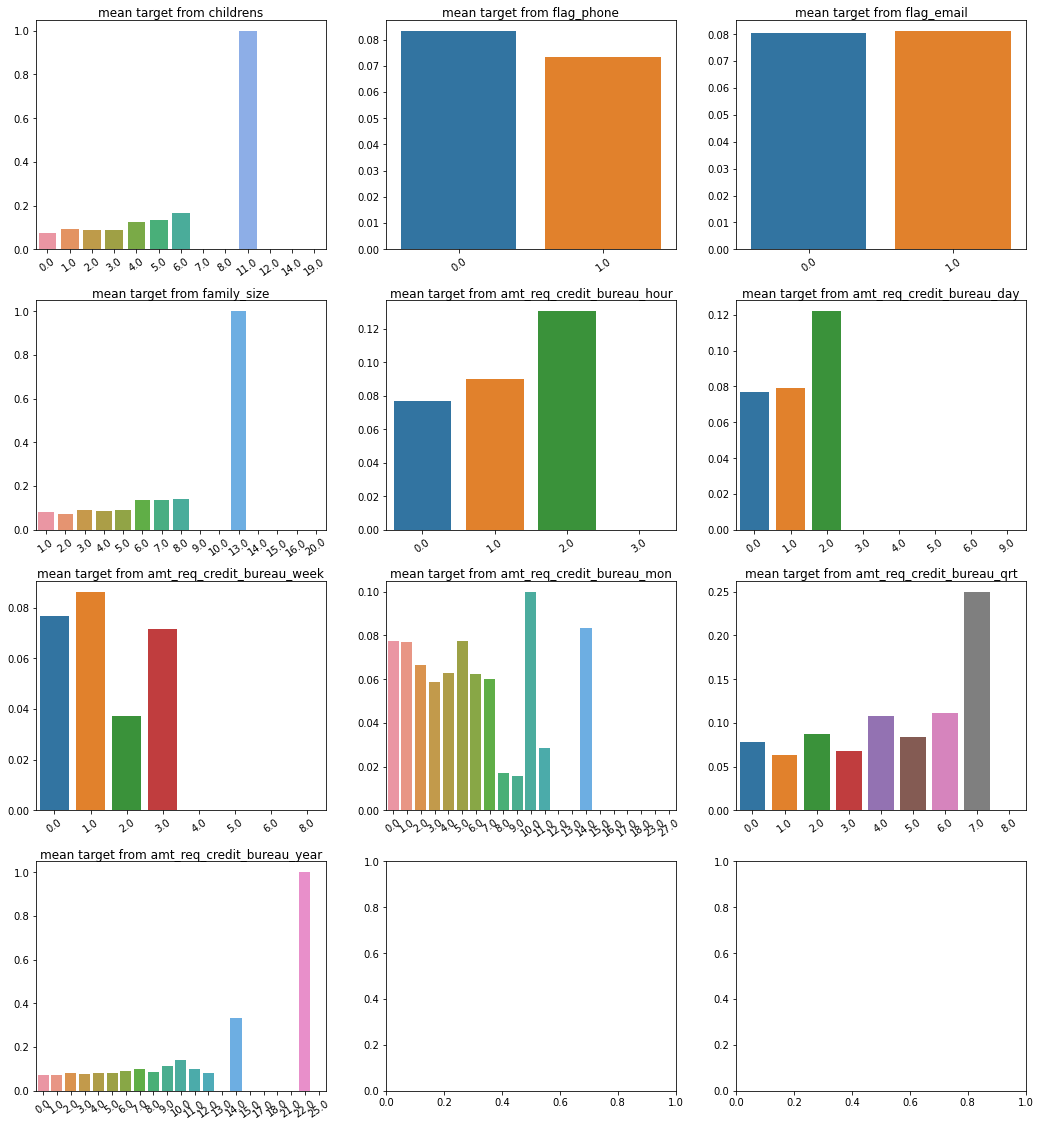

In [ ]:
mean_target_from_categorical(train_ext, discrete_features, 'target')

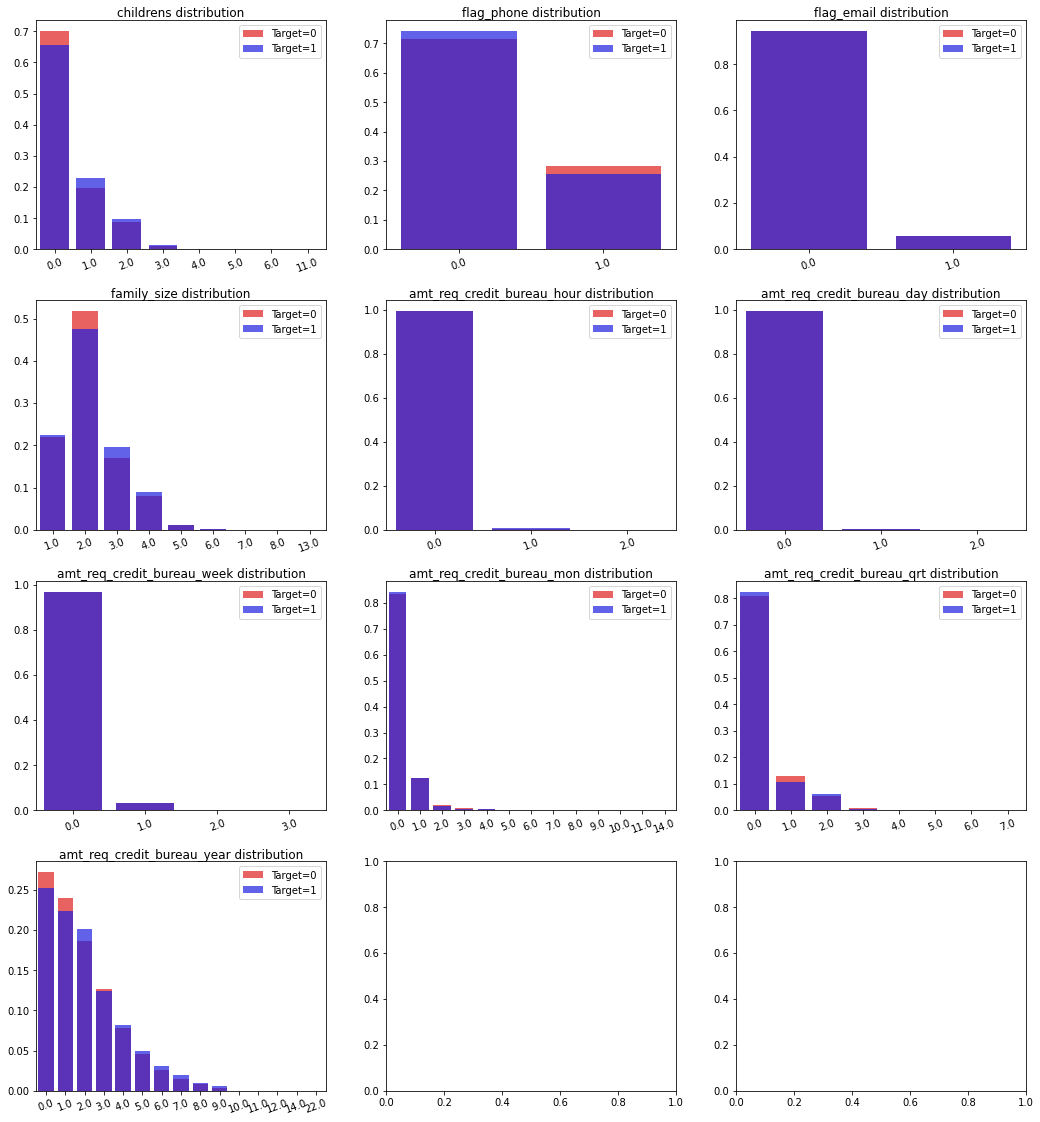

In [ ]:
get_cat_features_dist_from_target(train_ext, discrete_features, 'tagret', n_columns=3, sublot_size=(5, 4))

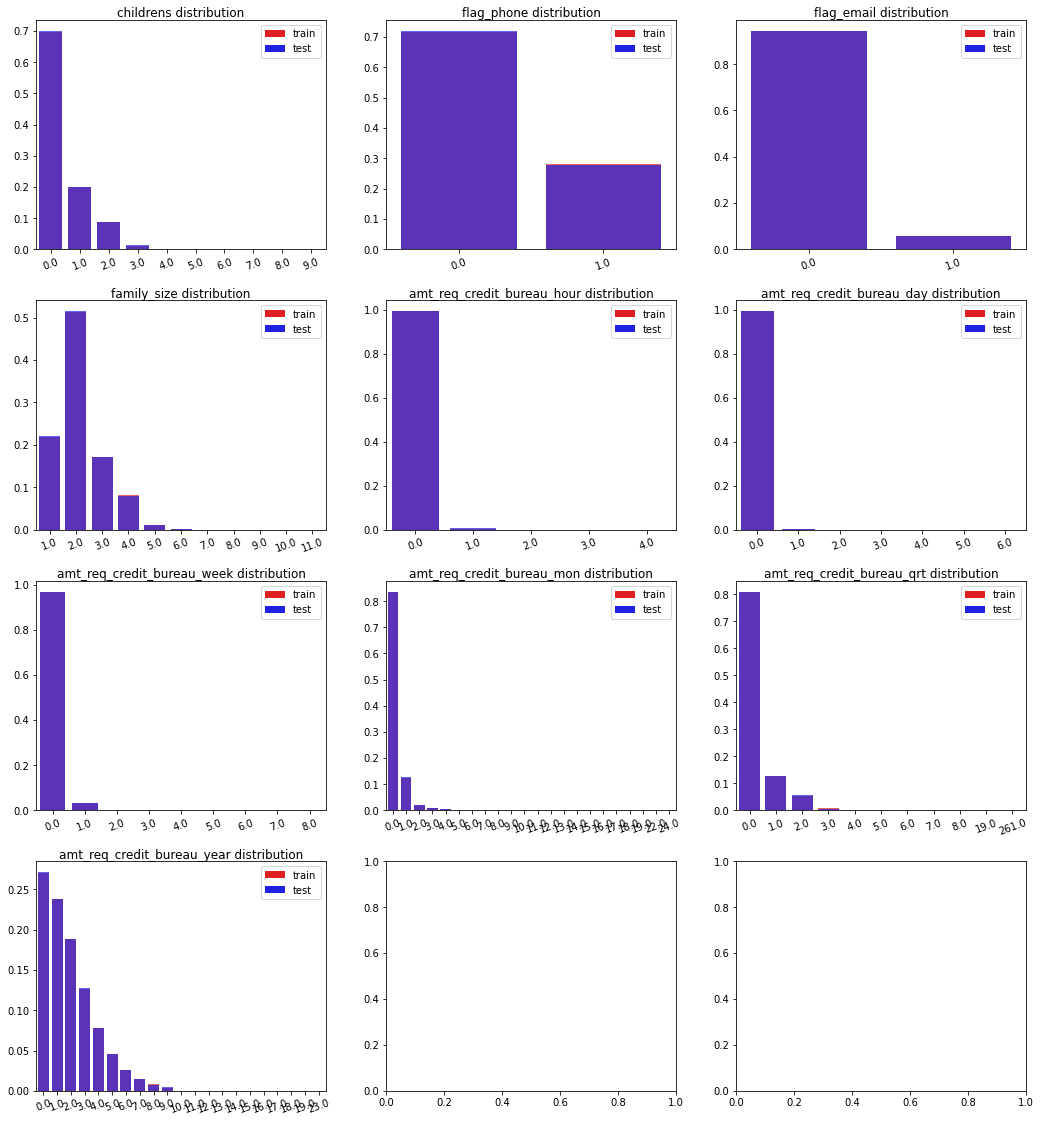

In [ ]:
get_train_test_cat_distr(train_ext, test_ext, discrete_features, n_columns=3)

## Оценка линейной зависимости между признаками

Text(0, 0.5, 'Density')

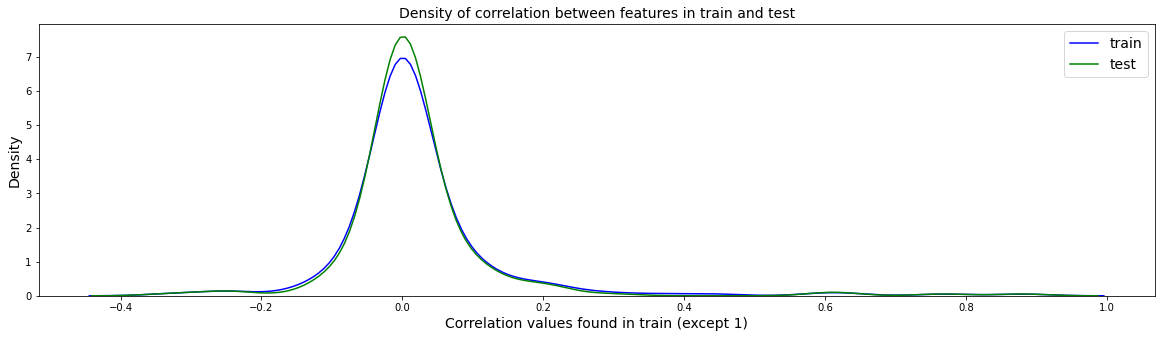

In [ ]:
train_correlations = train_ext.drop(columns=['target']).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test_ext.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.kdeplot(train_correlations, color="Blue", label="train")
sns.kdeplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Density of correlation between features in train and test", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

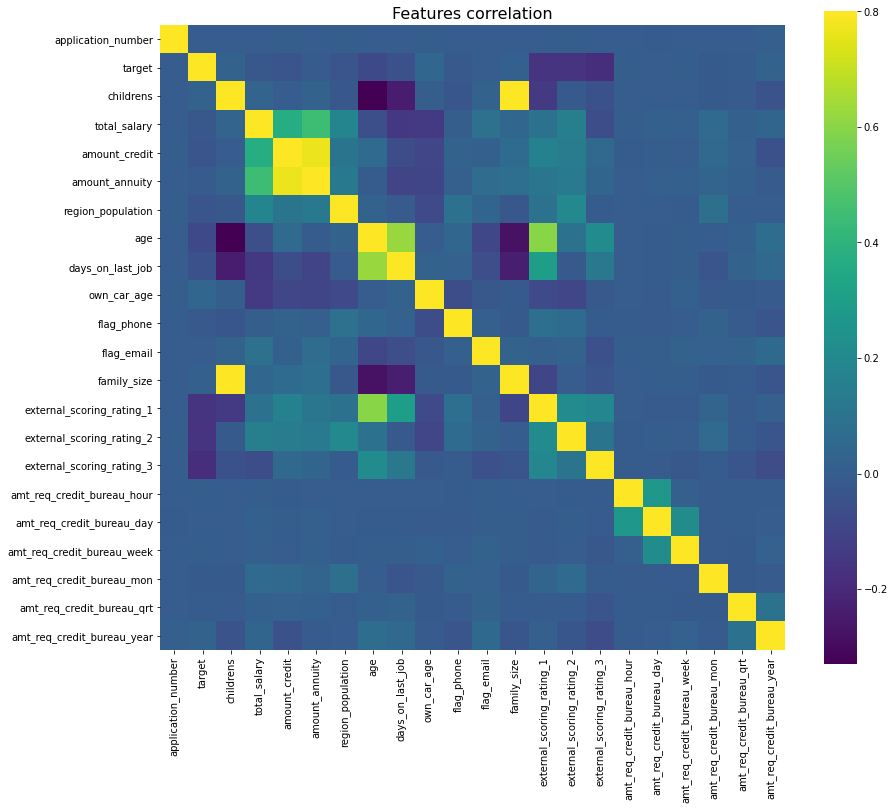

In [ ]:
correlation = train_ext.corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Features correlation", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

## Признаки с нелинейной связью с целевой переменной

In [ ]:
for feature in categorical_features:
    train_ext[feature] = pd.Series(train_ext[feature], dtype="category")

y_train = train_ext['target']
x_train = train_ext.drop(columns=['target'])

In [ ]:
lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 290,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

model_lgb = lgb.LGBMClassifier(**lgbm_params)
model_lgb.fit(x_train, y_train, categorical_feature=categorical_features)

Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


LGBMClassifier(boosting_type='gbdt', boosting_type ='gbdt', class_weight=None,
               colsample_bytree=1.0, device_type='cpu', importance_type='split',
               learning_rate=0.1, max_depth=3, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=290, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=100, seed=27, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

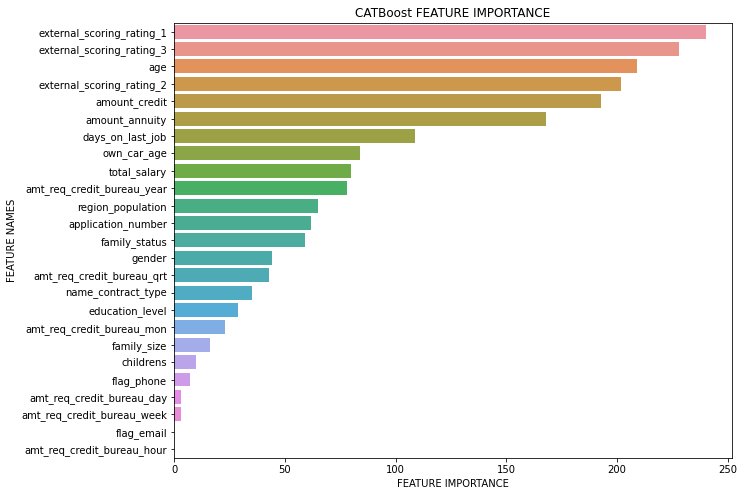

In [ ]:
top_features = plot_feature_importance(model_lgb.feature_importances_, x_train.columns, 'LGBM')

## Анализ идентичности распределения признаков в train и test через модель (adversarial validation) 

In [ ]:
def train_test_adv_validation(x_train: pd.DataFrame, 
                              x_test: pd.DataFrame, 
                              cateforical_features: List):
  X_adv = pd.concat([x_train, x_test])
  y_adv = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

  X_adv = X_adv.reset_index(drop=True)

  for feature in categorical_features:
    X_adv[feature] = pd.Series(X_adv[feature], dtype="category")
  
  dtrain = lgb.Dataset(data=X_adv, label=y_adv)
  
  lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
  }

  cv_result = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature=cateforical_features,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=5
  )
  
  lgbm_params['n_estimators'] = len(result['auc-mean'])

  model_lgb = lgb.LGBMClassifier(**lgbm_params)
  model_lgb.fit(X_adv, y_adv)
  importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model_lgb.feature_importances_
  })
  importance = importance.sort_values(by="adversarial_importance", ascending=False)
  importance = importance.head(n=10)

  plt.figure(figsize=(20, 5))
  sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
  plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)
  return model_lgb

categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


[10]	cv_agg's auc: 0.498334 + 0.00219548
[20]	cv_agg's auc: 0.498669 + 0.00209592
[30]	cv_agg's auc: 0.499164 + 0.00222964
[40]	cv_agg's auc: 0.499491 + 0.0019473
[50]	cv_agg's auc: 0.499533 + 0.00270164
[60]	cv_agg's auc: 0.499725 + 0.00228126
[70]	cv_agg's auc: 0.499955 + 0.00240193
[80]	cv_agg's auc: 0.500161 + 0.00226397
[90]	cv_agg's auc: 0.500008 + 0.00231133
[100]	cv_agg's auc: 0.499831 + 0.00214992
[110]	cv_agg's auc: 0.499895 + 0.00206623
[120]	cv_agg's auc: 0.500155 + 0.0022156
[130]	cv_agg's auc: 0.500357 + 0.00226786
[140]	cv_agg's auc: 0.50029 + 0.00182999
[150]	cv_agg's auc: 0.500487 + 0.0019038
[160]	cv_agg's auc: 0.50055 + 0.00232415
[170]	cv_agg's auc: 0.500469 + 0.00231171
[180]	cv_agg's auc: 0.500318 + 0.00206318
[190]	cv_agg's auc: 0.500568 + 0.00209155
[200]	cv_agg's auc: 0.500471 + 0.00226887
[210]	cv_agg's auc: 0.500735 + 0.00227287
[220]	cv_agg's auc: 0.500763 + 0.00199699
[230]	cv_agg's auc: 0.50068 + 0.00181475
[240]	cv_agg's auc: 0.500453 + 0.00153415
[250]	c

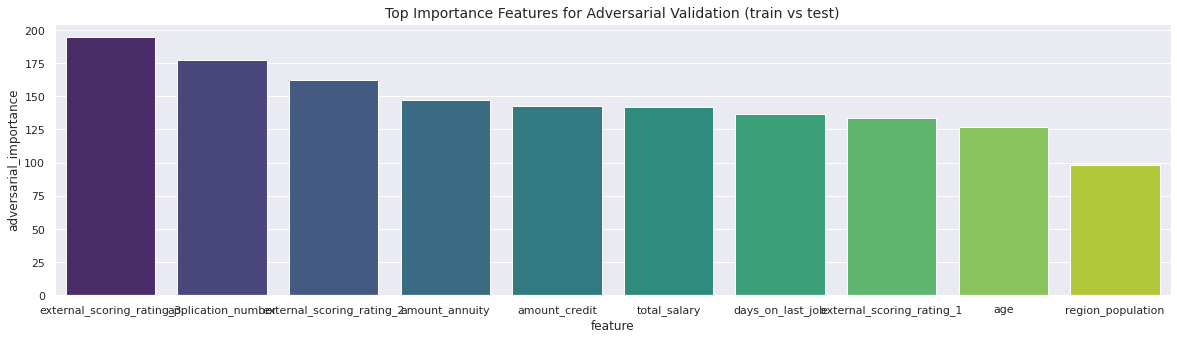

In [ ]:
lgb_model = train_test_adv_validation(x_train, test_ext, categorical_features)

## Анализ пропусков

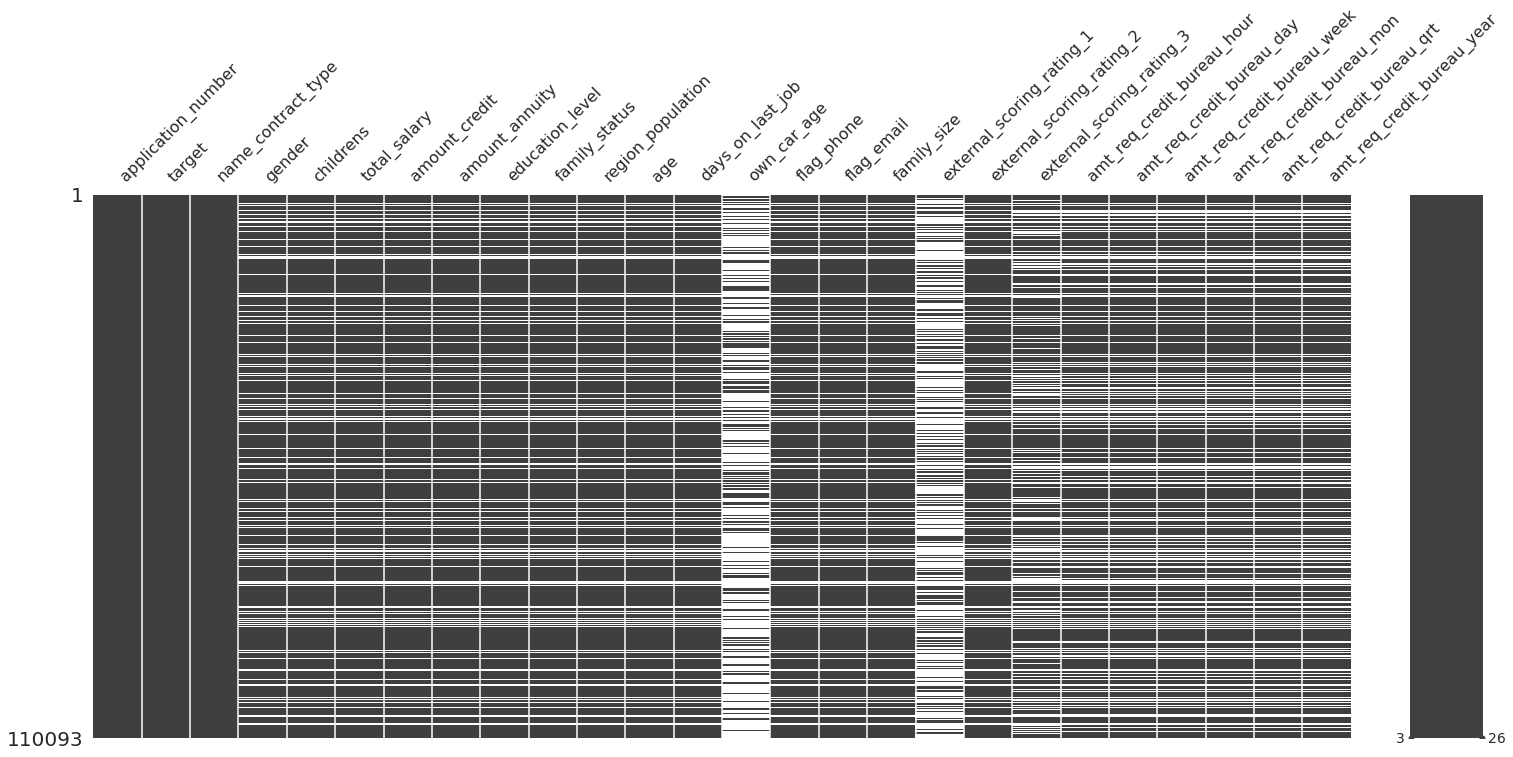

In [ ]:
msno.matrix(train_ext)

In [ ]:
def missing_features_target_distr(data: pd.DataFrame,
                                  target: str, 
                                  n_columns: int = 3,
                                  sublot_size: tuple = (5, 4),
                                  space: float = 3.0):

  features_with_na = [
    feature for feature in data.columns
    if data[feature].isnull().sum() > 1]
  
  n_rows = math.ceil((len(features_with_na)) / n_columns)
  fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  fig.tight_layout(pad=space)



  for num, feature in enumerate(features_with_na):
      data_t = data.copy()
      data_t[feature] = np.where(data_t[feature].isnull(), 1, 0)
      statistics = data_t.groupby(feature)["target"].mean()
      axes[num//n_columns, num%n_columns].bar(statistics.index, statistics.values)
      axes[num//n_columns, num%n_columns].set_xticks([0, 1])
      axes[num//n_columns, num%n_columns].set_xticklabels(["no missing", "missing"])
      axes[num//n_columns, num%n_columns].set_ylabel(feature)

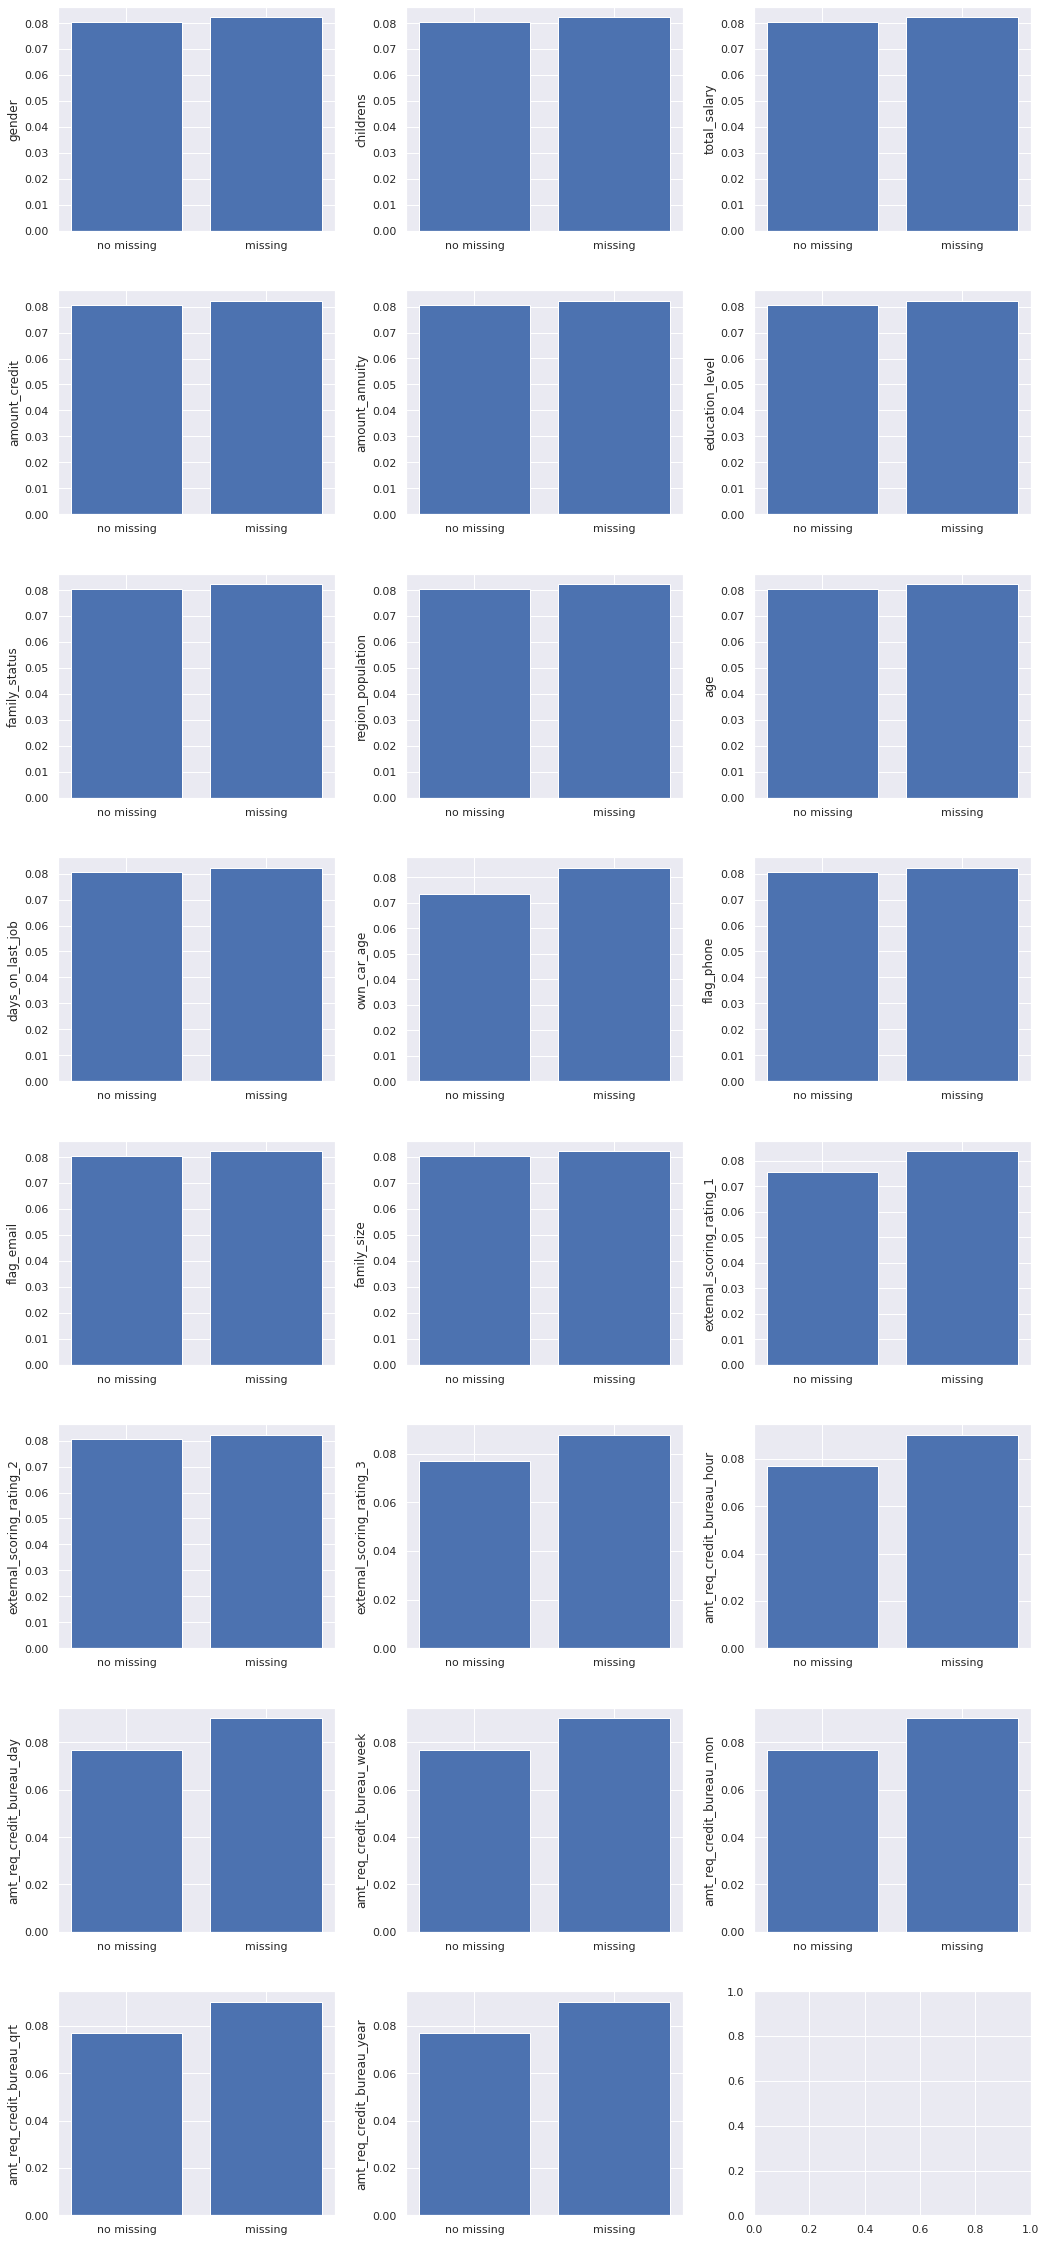

In [ ]:
missing_features_target_distr(train_ext, 'target')

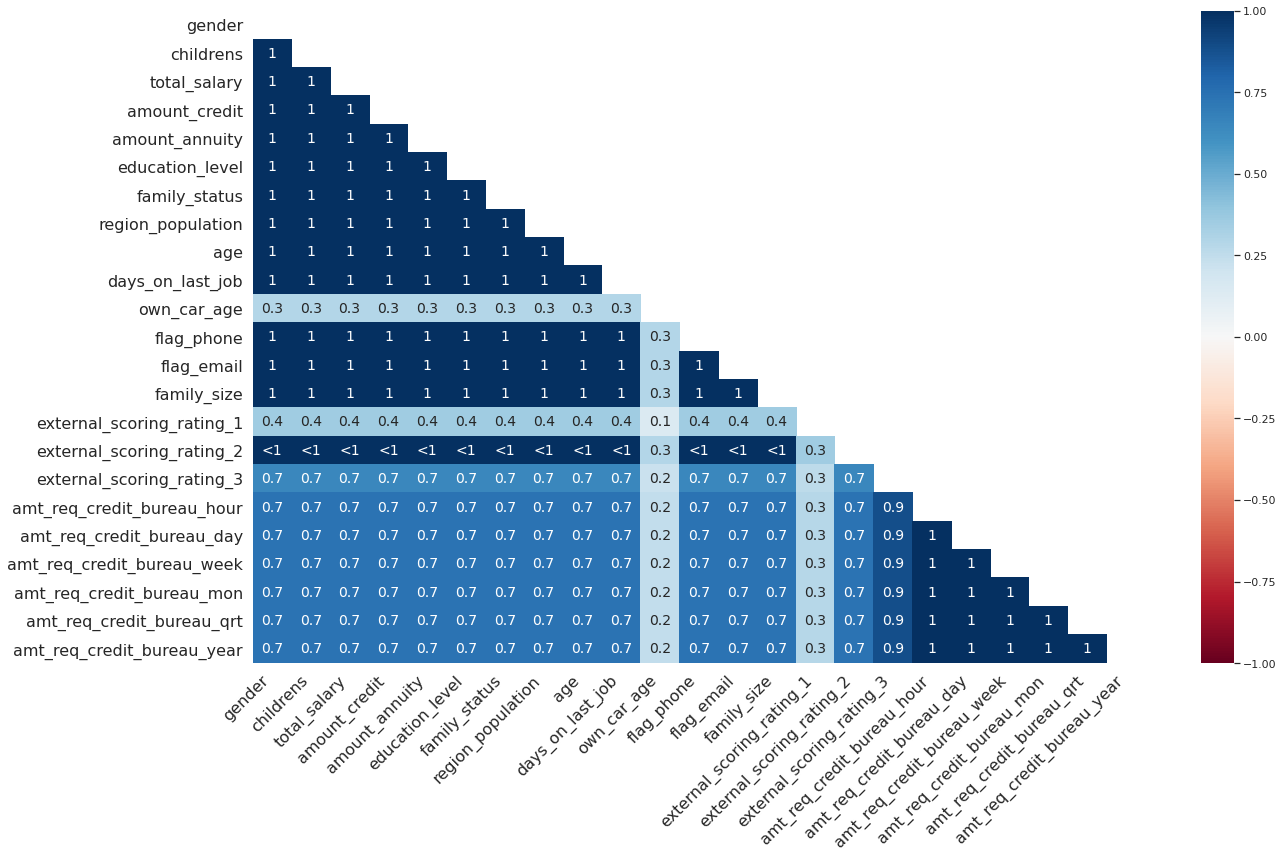

In [ ]:
msno.heatmap(train_ext)

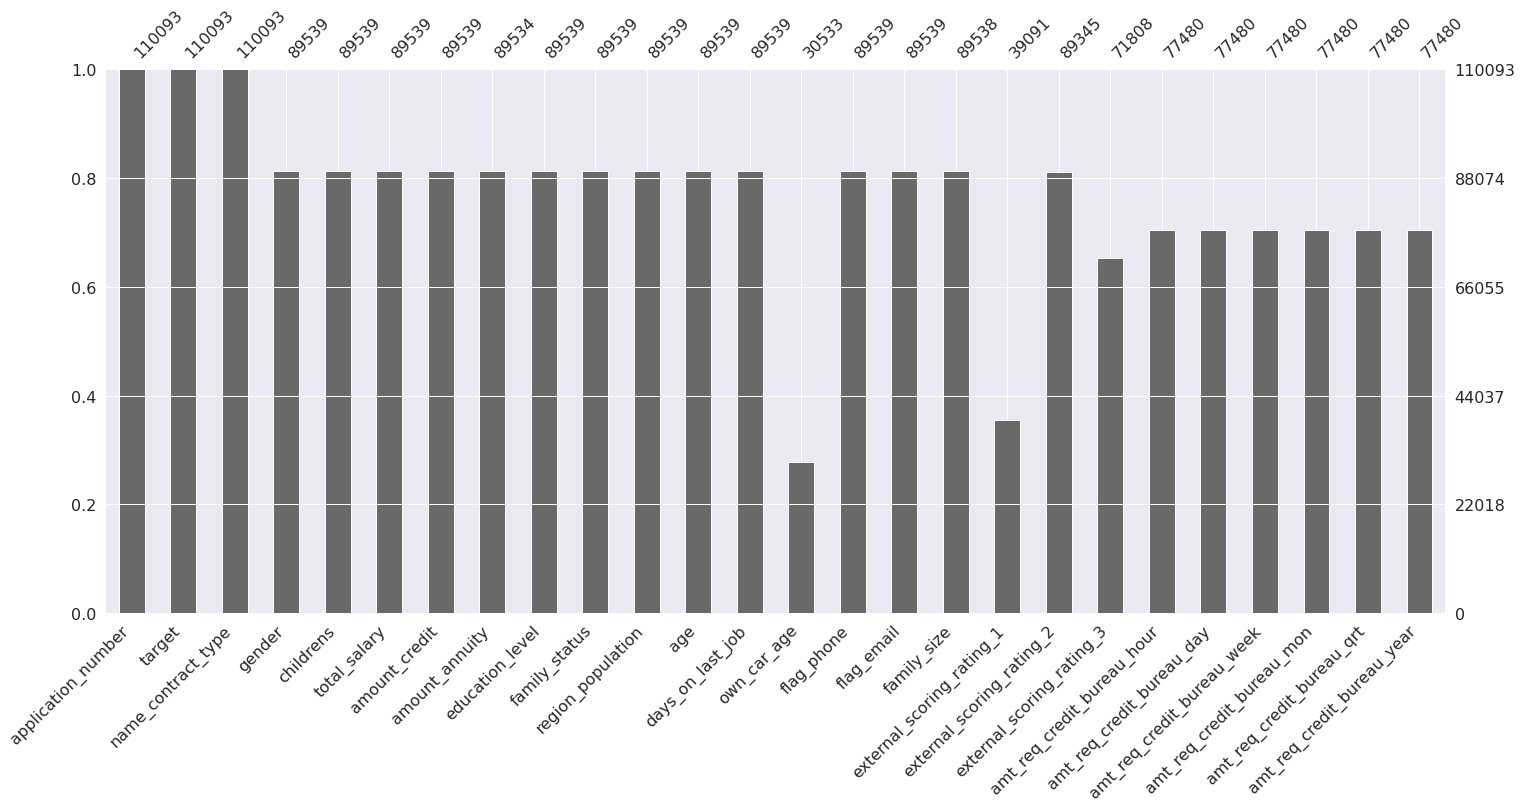

In [ ]:
msno.bar(train_ext, labels=True)

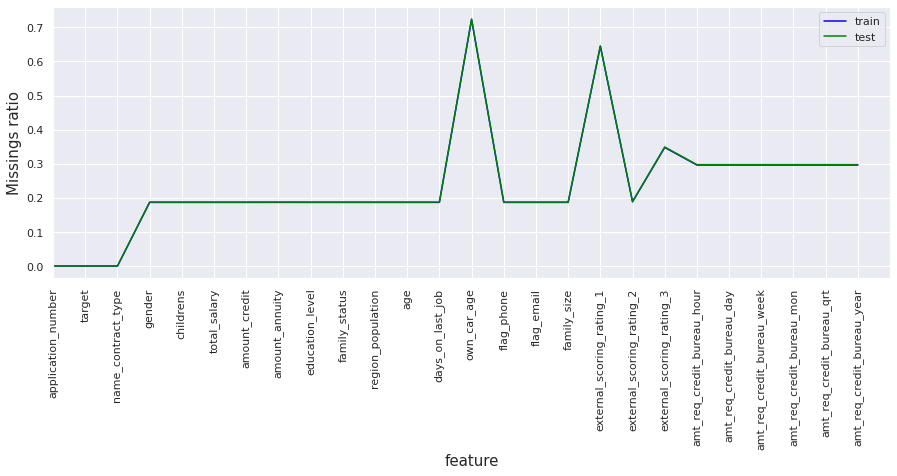

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_ext.isnull().mean(), label="train", color="blue")
plt.plot(test_ext.isnull().mean(), label="test", color="green")
plt.xticks(range(train_ext.shape[1]), train_ext.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train_ext.shape[1])
plt.legend()